## Test Feature Engineering to Predict Risk of Stroke

In this section, differnt grams to process the text is tested and compared.

### 1. Split train and test data
To test a model, the data are first separated into train (80%) and test (20%) data. The train data are used for training and cross-validation for each model. The test data are used to evaluate the final performance of each model.

In [1]:
# import library
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import re
# set matplotlib style
%matplotlib inline
matplotlib.style.use('ggplot')
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

# read data from csv file
train_val_data = pd.read_csv('stroke_his_info.csv')

# get the midical, social and family history information
X = train_val_data['HISTORY INFO'].values
# get a list of labels (stroke or non-stroke)
labels = train_val_data['STROKE_LABEL'].values
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20,\
                                                    random_state = 42)
# examine the data shape in train and test data
print 'Train data: ', X_train.shape
print 'Test data: ', X_test.shape

Train data:  (3020,)
Test data:  (755,)


### 2. Natural language processing text notes
Because the data are texts, they have to be transformed before applying for a model. To do that, the history notes are tokenizer with stemming and converted into term frequency–inverse document frequency with TfidfVectorizer with different ngrams.

#### 2.1 Transform the labels

In [2]:
# transform labels
# define a dict to with key as a label and value as a numeric value
labels_dict = {'Stroke':1, 'Non-Stroke':0}
y_train_transform = [labels_dict[key] for key in y_train]
# examine the number of labels
print 'There are %d labels'%(len(y_train_transform))

There are 3020 labels


#### 2.2 Feature engineering and selection

In [3]:
# import snow ball stemmmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
def tokenizer(text):
    '''
    this function define a stemming to tokenizer words in the text
    '''
    stemmed = []
    # remove special characters and blank space
    text = re.sub('[^a-zA-Z0-9]+', ' ', text)
    text = re.sub('[ ]+', ' ', text)
    text.strip()
    # stemmized each word and return a list of the stemmized words
    words = text.split()
    for item in words:
        stemmed.append(stemmer.stem(item))   
    return stemmed

In [4]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

def feature_selection(clf, X, y, vec, title, xlabel, is_test = True):
    '''
    this function is used to train a model for feature selection
    '''
    # fit a classifier for feature selection model
    clf.fit(X, y)
    # apply the classifier to the model for feature selection
    model = SelectFromModel(clf, prefit=False)
    # get the selected new features
    X_new = model.fit_transform(X,y)
    print 'There are %d features selected with %s' %(X_new.shape[1], xlabel)
    # the following code is used to plot a graph for train data to visulize the 
    # selected features when the value of is_test is False. 
    if not is_test:
        # define the figure
        plt.Figure(figsize = (10, 16))
        # get the coefficient (or weight) for each feature
        coef = clf.coef_[0]
        # sort the index of coef according to the coef value
        indices = np.argsort(coef)[::-1]
        # get the index of coef which has a positive coef
        indices = [i for i in indices if coef[i] != 0]
        # get the feature_names
        feature_names = vec.get_feature_names()
        # get the interesting features that are relevant to stroke and their coef
        top_10_positive_coef = [coef[i] for i in indices[:14]]
        top_10_positive_coef += [coef[indices[28]]]
        top_10_positive_terms = [feature_names[i] for i in indices[:14]]
        top_10_positive_terms += [feature_names[indices[28]]]
        # use the pandas datafram to plot a graph for selected features
        df = pd.DataFrame({'Stroke relevant': top_10_positive_coef})
        df.index = top_10_positive_terms
        df.plot(kind = 'barh', color = 'darkblue')
        plt.gca().invert_yaxis()
        plt.legend().set_visible(False)
        plt.title(title, y = 1.1)
        plt.xlabel(xlabel)
        
    # return the selected features and the model used for selection    
    return X_new, model

In [5]:
from sklearn.model_selection import GridSearchCV
def search_best_params(X, y, clf, params):
    '''
    this method searchs the best parameters for a classifier
    '''
    model = GridSearchCV(clf, params, cv = 5, n_jobs =1, scoring = 'recall_macro')
    model.fit(X, y)
    best_parameter = model.best_params_
    return best_parameter

#### 2.3 Train LogidticRegression and Support Vector Machine models with differnt ngrams

In [6]:
# converted notes into occurance of words with sklearn CountVectorizer
# start from 2 grams in order to avoid overfitting and test up to 10 grams
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, classification_report
import time
n = 5
ngrams = []
lr_preds = []
svc_preds = []
lr_times = []
svc_times = []
# transform the labels for test data
y_test_transform = [labels_dict[y] for y in y_test]
# set up ngrams
for i in range(2, n + 1):
    for j in range(2, i + 1):
        ngrams.append((j, i))
for ngram in ngrams:
    print 'The ngram is %s: '%(str(ngram))
    # converted notes into term frequency–inverse document frequency with TfidfVectorizer
    tfidf_vec = TfidfVectorizer(ngram_range = ngram, stop_words = 'english', tokenizer = tokenizer)
    X_transform_tfidf = tfidf_vec.fit_transform(X_train)
    print ('The number of features with tfidf vectorizer transformation: %d'%X_transform_tfidf.shape[1])
    X_test_tfidf = tfidf_vec.transform(X_test)
    print X_test_tfidf.shape
    # define the default models
    lsvc_tfidf = LinearSVC(penalty='l1', dual = False, random_state = 42)
    # define the search parameters
    svc_parameters = {'C' : [0.1, 0.2, 0.25, 0.5, 10, 50, 100, 500]} 
    # search best parameters
    best_params_tfidf_select = search_best_params(X_transform_tfidf, y_train_transform, 
                                              lsvc_tfidf, svc_parameters)
    print 'Best parameter for feature selection (tfidf): ', best_params_tfidf_select
    lsvc_tfidf_select = LinearSVC(penalty='l1', dual = False, random_state = 42, 
                              **best_params_tfidf_select)
    # select features
    title_tfidf = 'Stroke relevant features'
    xlabel= 'Tfidf'
    title_count = 'Stroke relevant features (Word occurance based)'
    X_train_tfidf_selected, model_tfidf = feature_selection(lsvc_tfidf_select, X_transform_tfidf, 
                                            y_train_transform, tfidf_vec, title_tfidf, xlabel)
    # setup LogisticRegression classifiers
    lr_clf_tfidf = LogisticRegression(random_state=42)
    # setup parameters for searching: tol - Tolerance for stopping criteria; C - Inverse of 
    # regularization strength; must be a positive float. Like in support vector machines, 
    # smaller values specify stronger regularization; penalty - Used to specify the norm used 
    # in the penalization.
    lr_parameters = {'tol' : np.logspace(-8, -3, 5),
                     'C' : np.logspace(-3, 3, 6),
                    'penalty': ['l1', 'l2']} 
    # search best parameters
    lr_best_params_tfidf = search_best_params(X_train_tfidf_selected, y_train_transform, lr_clf_tfidf,
                                      lr_parameters)
    print 'Best parameters for tfidf vectorizer (Logistic Regression): ', lr_best_params_tfidf
    
    # set up SVM classifiers
    svc_clf_tfidf = LinearSVC(random_state = 42)
    # set up parameters for optimization: tol - Tolerance for stopping criteria; 
    # C - Penalty parameter C of the error term;
    # max_iter - The maximum number of iterations to be run
    # loss - Specifies the loss function. ‘hinge’ is the standard SVM loss 
    # (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss. 
    svc_parameters = {'tol' : np.logspace(-8, -3, 5),
                     'C' : np.logspace(-3, 3, 6),
                     'max_iter' : [50, 100, 200, 500, 1000],
                     'loss' : ['hinge', 'squared_hinge']} 
    # search parameters for SVM trained with CountVectorizer transformed data
    # search parameters for SVM trained with TfidfVectorizer transformed data
    svc_best_params_tfidf = search_best_params(X_train_tfidf_selected, y_train_transform, svc_clf_tfidf,
                                      svc_parameters)
    print 'Best parameters for tfidf vectorizer (SVM): ', svc_best_params_tfidf
    
    # transform test data
    X_test_tfidf = tfidf_vec.transform(X_test)
    # apply feature selection model for test data
    X_test_tfidf_selected = model_tfidf.transform(X_test_tfidf)

    # set up LogisticRegression classifiers
    lr_clf_tfidf_best = LogisticRegression(random_state=42,**lr_best_params_tfidf)
    # set up SVM classifiers
    svc_clf_tfidf_best = LinearSVC(random_state = 42, **svc_best_params_tfidf)

    # train LogisticRegression classifier with TfidfVectorizer transformated data and predict
    t0 = time.time()
    lr_clf_tfidf_best.fit(X_train_tfidf_selected,y_train_transform)
    pred_lr_tfidf_best = lr_clf_tfidf_best.predict(X_test_tfidf_selected)
    t1 = time.time()
    lr_preds.append(pred_lr_tfidf_best)
    lr_times.append(t1 - t0)
    
    # train SVM classifier with TfidfVectorizer transformated data and predict
    t2 = time.time()
    svc_clf_tfidf_best.fit(X_train_tfidf_selected, y_train_transform)
    pred_svc_tfidf_best = svc_clf_tfidf_best.predict(X_test_tfidf_selected)
    t3 = time.time()
    svc_preds.append(pred_svc_tfidf_best)
    svc_times.append(t3 - t2)
    print '\n'
print 'training completed'

The ngram is (2, 2): 
The number of features with tfidf vectorizer transformation: 67223
(755, 67223)
Best parameter for feature selection (tfidf):  {'C': 0.5}
There are 252 features selected with Tfidf
Best parameters for tfidf vectorizer (Logistic Regression):  {'penalty': 'l2', 'C': 1000.0, 'tol': 1e-08}
Best parameters for tfidf vectorizer (SVM):  {'loss': 'hinge', 'C': 63.0957344480193, 'max_iter': 1000, 'tol': 1e-08}


The ngram is (2, 3): 
The number of features with tfidf vectorizer transformation: 175496
(755, 175496)
Best parameter for feature selection (tfidf):  {'C': 100}
There are 2386 features selected with Tfidf
Best parameters for tfidf vectorizer (Logistic Regression):  {'penalty': 'l2', 'C': 1000.0, 'tol': 1e-08}
Best parameters for tfidf vectorizer (SVM):  {'loss': 'squared_hinge', 'C': 1000.0, 'max_iter': 1000, 'tol': 1e-08}


The ngram is (3, 3): 
The number of features with tfidf vectorizer transformation: 108273
(755, 108273)
Best parameter for feature selection 

### 3. Final comparisons
Finally, the models with optimized parameters are compared with test data based on their perdiction performance and running time.

               accu_score  precision  recall_score      time
ngrams (2, 2)   73.642384  73.745451     73.628810  0.032727
ngrams (2, 3)   69.801325  69.923470     69.785059  0.029957
ngrams (3, 3)   67.417219  67.628401     67.394599  0.027507
ngrams (2, 4)   72.715232  73.025791     72.691644  0.031034
ngrams (3, 4)   68.476821  68.748663     68.452114  0.035434
ngrams (4, 4)   66.622517  66.780832     66.640936  0.030621
ngrams (2, 5)   72.980132  73.324421     72.955496  0.031014
ngrams (3, 5)   67.814570  68.064185     67.790378  0.043911
ngrams (4, 5)   67.814570  68.152739     67.840903  0.030426
ngrams (5, 5)   53.774834  57.141676     53.635687  0.041074
               accu_score  precision  recall_score      time
ngrams (2, 2)   73.245033  73.411772     73.227769  0.035333
ngrams (2, 3)   69.403974  69.440927     69.394543  0.133792
ngrams (3, 3)   66.490066  66.763483     66.463748  0.034352
ngrams (2, 4)   69.668874  69.898721     69.646817  0.086553
ngrams (3, 4)   66.49006

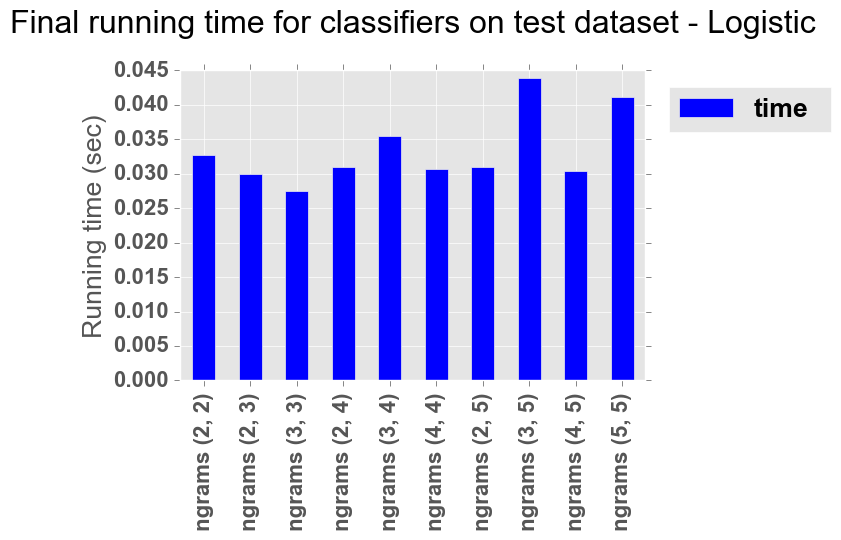

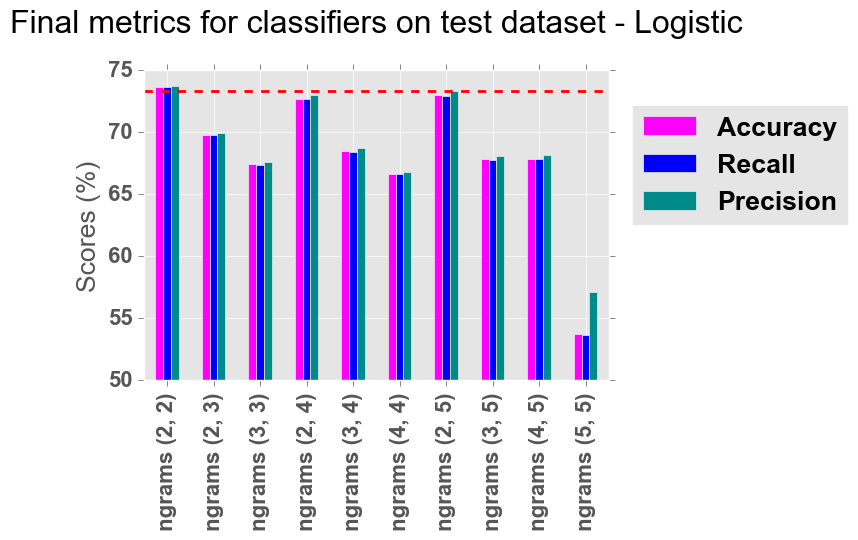

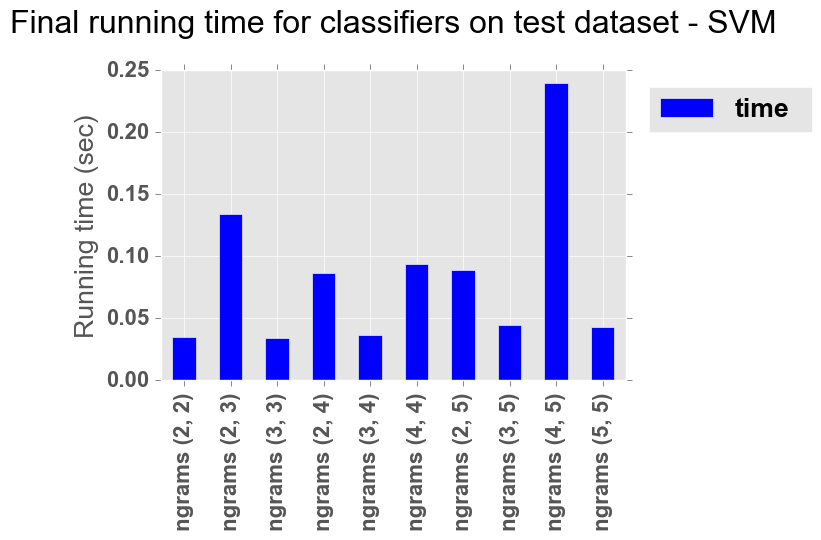

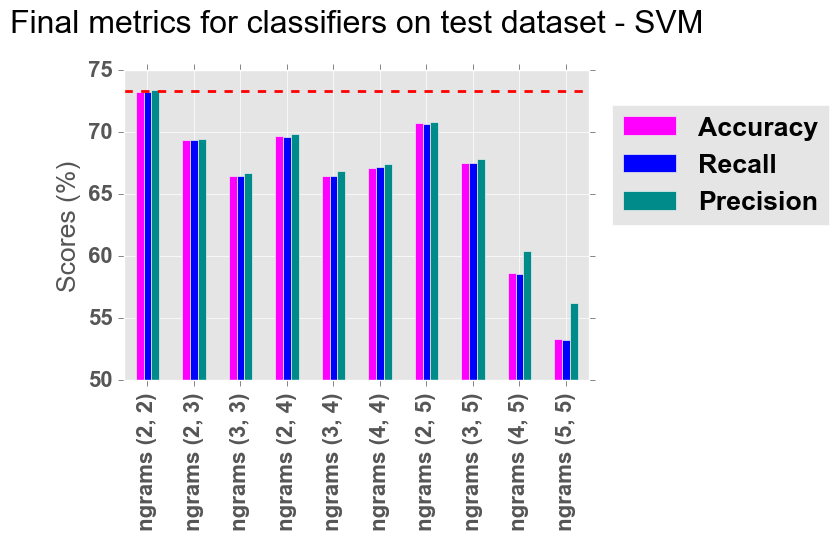

In [9]:
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, classification_report

# print out final comparison results
def plot_metrics(preds, times, index, title):
    '''
    define function to plot metrics graphs
    '''
    # LogisticRegression
    accuracy_scores = [accuracy_score(y_test_transform, pred)*100 for pred in preds]
    recall_scores = [recall_score(y_test_transform, pred, average = 'macro')*100 for pred in preds]
    precision_scores = [precision_score(y_test_transform, pred, average = 'macro')*100 for pred in preds]
    f1_scores = [f1_score(y_test_transform, pred)*100 for pred in preds]
    # put data into pandas dataframe
    df = pd.DataFrame({'time':times, 'accu_score': accuracy_scores, 'recall_score': recall_scores, 
                   'precision': precision_scores})
    df.index = index
    # print the data
    print df
    plt.Figure(figsize = (15,8))
    df[['time']].plot(kind = 'bar', color = ['b'], rot = 90)
    plt.legend(['time'], bbox_to_anchor=(1.05, .8, 0.35, 0),loc=3, mode="expand",
                   borderaxespad=0.)
    plt.ylabel('Running time (sec)')
    plt.title('Final running time for classifiers on test dataset - ' + title, y = 1.1)
    # plot the final metrics graph
    plt.Figure(figsize = (15,8))
    df_1 = df[['accu_score', 'recall_score', 'precision']]
    df_1.plot(kind = 'bar', color = ['magenta', 'blue', 'darkcyan'], rot = 90)
    plt.ylim([50, 75])
    plt.legend(['Accuracy', 'Recall', 'Precision'], bbox_to_anchor=(1.05, 0.5, 0.75, 0),loc=3,
                   borderaxespad=0.)
    plt.axhline(y = 73.3, color = 'red', linestyle='dashed', linewidth=2)
    plt.ylabel('Scores (%)')
    plt.title('Final metrics for classifiers on test dataset - ' + title, y = 1.1)

# plot metrics for logistic regression
index = ['ngrams ' + str(gram) for gram in ngrams]
plot_metrics(lr_preds, lr_times, index, 'Logistic')

# plot metrics for SVM
plot_metrics(svc_preds, svc_times, index, 'SVM')

The LogisticRegression classifier trained with TfidfVectorizer transformated data using bigrams yields best performance of prediction based on the metrics of recall.